Scadi Dataset is  contains 206 attributes of 70 children with physical and motor disability based on ICF-CY and was donated by S.M.M. Fatemi Bushehri for research purposes. The 'Class' field refers to the presence of the self-care problems of the children with physical and motor disabilities and are determined by occupational therapists. 

In [111]:
import xgboost as xgb  
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,  StratifiedKFold,KFold
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA,TruncatedSVD,KernelPCA
from termcolor import colored
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import graphviz 
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from imblearn.combine import SMOTEENN,SMOTETomek
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Let's set up the Classifiers.

In [112]:
xgb1 = xgb.XGBClassifier(early_stopping=4,max_depth=4,learning_rate=0.001,n_estimators=30,booster='gbtree',min_samples_split =2)
forest=RandomForestClassifier(max_depth = 5,bootstrap=True, n_estimators=150, max_features=3,min_samples_split=3,n_jobs=1,criterion="entropy")
cart=DecisionTreeClassifier(criterion ="gini",splitter="best",max_depth=7)
adaboost=AdaBoostClassifier(tree.DecisionTreeClassifier(criterion ="gini",splitter="best",max_depth=4,min_samples_split =2,
                               min_samples_leaf=2,max_features=3,max_leaf_nodes = 4),
                               n_estimators=300,
                               learning_rate=0.01) 
svm=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)
neural=MLPClassifier(early_stopping =False,hidden_layer_sizes = 150 ,solver='lbfgs')
naive_bayes=GaussianNB()
knn=KNeighborsClassifier(n_neighbors=2,weights= "distance",algorithm ="kd_tree",leaf_size =30,p=1)

In [113]:
filepath = input('Give filepath to Dataset : ')
train=pd.read_csv(str(filepath), engine='python',error_bad_lines=False)
y = train['Classes']
X=train.drop(['Classes'],axis=1)
train.head()

Give filepath to Dataset : C:\Users\Socrates\Desktop\Διπλωματικη\scadi\SCADI.csv


,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-8,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9,Classes
0,0,18,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,class6
1,0,22,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,class6
2,0,18,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,class6
3,1,18,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,class6
4,0,19,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,class6


One common problem for medical datasets is that the dataset may contain a small number of samples.In this case, our dataset not only has a small number of instances (70 cases of children) but also the class feature has 7 label, making it difficult to make a model with high accuracy for each class label without overfitting.Let's have a look at the frequency of each class label and the number of instances for each label. 

In [114]:
print('percentage of class 1:',100*len(train.loc[train.Classes=='class1'])/float(len(train.Classes)), '%')
print('percentage of class 2:',100*len(train.loc[train.Classes=='class2'])/float(len(train.Classes)), '%')
print('percentage of class 3:',100*len(train.loc[train.Classes=='class3'])/float(len(train.Classes)), '%')
print('percentage of class 4:',100*len(train.loc[train.Classes=='class4'])/float(len(train.Classes)), '%')
print('percentage of class 5:',100*len(train.loc[train.Classes=='class5'])/float(len(train.Classes)), '%')
print('percentage of class 6:',100*len(train.loc[train.Classes=='class6'])/float(len(train.Classes)), '%')
print('percentage of class 7:',100*len(train.loc[train.Classes=='class7'])/float(len(train.Classes)), '%')

print('samples of class 1:',len(train.loc[train.Classes=='class1']))
print('samples of class 2:',len(train.loc[train.Classes=='class2']))
print('samples of class 3:',len(train.loc[train.Classes=='class3']))
print('samples of class 4:',len(train.loc[train.Classes=='class4']))
print('samples of class 5:',len(train.loc[train.Classes=='class5']))
print('samples of class 6:',len(train.loc[train.Classes=='class6']))
print('samples of class 7:',len(train.loc[train.Classes =='class7']))

percentage of class 1: 2.857142857142857 %
percentage of class 2: 10.0 %
percentage of class 3: 1.4285714285714286 %
percentage of class 4: 17.142857142857142 %
percentage of class 5: 4.285714285714286 %
percentage of class 6: 41.42857142857143 %
percentage of class 7: 22.857142857142858 %
samples of class 1: 2
samples of class 2: 7
samples of class 3: 1
samples of class 4: 12
samples of class 5: 3
samples of class 6: 29
samples of class 7: 16


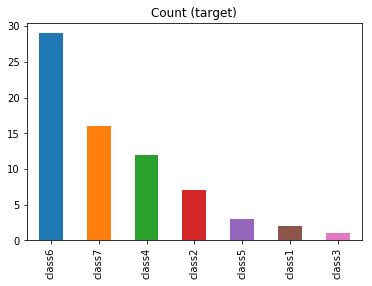

In [115]:
train.Classes.value_counts().plot(kind='bar', title='Count (target)')

Class label 1 appears only 2 times in the dataset while class label 3 only once making it really hard to build a model that predicts those label. To overcome this difficulty i will use  random oversampling. An alternative would be to use a technique called S.M.O.T.E (Synthetic Minority Over-sampling Technique) introduced in 2002 by Chawla, Bowyer, Hall & Kegelmeyer. 

In [116]:
# we can either choose the number of samples we want to add to each label by passing a dictionary
#dic={'class3':13,'class1':13,'class5':13}
#ros = RandomOverSampler(dic)
# or we can let it choose by itself.
ros = RandomOverSampler()
#sme = SMOTE(ratio='minority')
X_ros,y_ros=ros.fit_sample(X, y)

In [117]:
print(X_ros.shape[0] - X.shape[0], 'new random picked points')

133 new random picked points


In [118]:
X_ros=pd.DataFrame(data=X_ros,columns=X.columns)
y_ros=pd.DataFrame(data=y_ros)

To test the strength of our model we are going to use 10-fold cross validation

In [119]:
cv = KFold(n_splits=10,shuffle=True,random_state = 666)

In [120]:
counter = 0
mean_xgb=[]

for train, test in cv.split(X_ros, y_ros):
    counter +=1
    xgb1.fit(X_ros.loc[train], y_ros.loc[train])
    y_pred = xgb1.predict(X)
    accuracy=accuracy_score( y_pred, y )
    mean_xgb.append(accuracy)

    print(' xgb accuracy in ',counter,' fold : ',accuracy)
mean_xgb=np.array(mean_xgb)

C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  1  fold :  0.9571428571428572


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  2  fold :  0.9571428571428572


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  3  fold :  0.9857142857142858


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  4  fold :  0.9428571428571428


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  5  fold :  0.9428571428571428


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  6  fold :  0.9428571428571428


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  7  fold :  0.9571428571428572


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  8  fold :  0.9571428571428572


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  9  fold :  0.9285714285714286


C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Socrates\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 xgb accuracy in  10  fold :  0.9714285714285714


In [121]:
print('mean accuracy of xgb =',np.mean(mean_xgb))
print('SD of xgb accuracy =',np.std(mean_xgb))

mean accuracy of xgb = 0.9542857142857143
SD of xgb accuracy = 0.01538618516324145


Let's have a look at the confusion Matrix

In [122]:
confusion_matrix(y_pred,y)

array([[ 2,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  1,  0],
       [ 0,  0,  0,  0,  3,  0,  1],
       [ 0,  0,  0,  0,  0, 28,  0],
       [ 0,  0,  0,  0,  0,  0, 15]], dtype=int64)

Let's get a prettier confusion matrix!

In [123]:
confusion_matrix=confusion_matrix(y_pred,y)

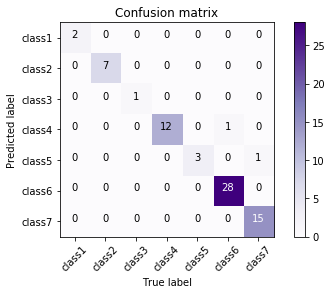

In [124]:
import itertools
cm=confusion_matrix 
classes=[]
temp=[]
for i in range(len(y_pred)):
    if y_pred[i] not in y.unique():
        if y_pred[i] not in temp:
            temp.append(y_pred[i])
for i in range (len(y.unique())):
    classes.append(y.unique()[i])
for i in range(len(temp)):
    classes.append(temp[i])
classes=sorted(classes)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt ='d' #'.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.xlabel('True label')    
plt.ylabel('Predicted label')
plt.show()